## Load Dataset

In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Define the model

conv -> pool -> conv -> pool -> conv -> avg pool -> fc

In [7]:
def complex_conv(X_, filters, kernel_size, strides, padding, initializer, regularizer, dropout_rate, is_training_, name):
    # dropout -> conv -> bn -> relu
    
    # combo layers
    with tf.variable_scope(name):
        out = X_
        out = tf.layers.dropout(out, rate=dropout_rate, training=is_training_, name="dropout")
        out = tf.layers.conv2d(out, filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, 
            activation=None, kernel_initializer=initializer, kernel_regularizer=regularizer, name="conv")
        out = tf.layers.batch_normalization(out, axis=-1, training=is_training_, name="bn")
        out = tf.nn.relu(out)

    return out
    
def model_op(X_, y_, is_training_, reg_rate, dropout_rate=0.):
    
    xavier_conv2d = tf.contrib.layers.xavier_initializer_conv2d() # use Xavier initializer
    xavier_init = tf.contrib.layers.xavier_initializer() # use Xavier initializer
    regularizer = tf.contrib.layers.l2_regularizer(reg_rate)

    with tf.variable_scope("layer1"):
        out = complex_conv(X_, filters=32, kernel_size=[3,3], strides=(1,1) , padding='valid', 
                    initializer=xavier_conv2d, regularizer=regularizer, dropout_rate=dropout_rate, 
                    is_training_=is_training_, name="conv1")
        out = tf.layers.max_pooling2d(out, pool_size=[2, 2], strides=2, name="pool")

    with tf.variable_scope("layer2"):
        out = complex_conv(out, filters=64, kernel_size=[2,2], strides=(1,1) , padding='valid', 
                    initializer=xavier_conv2d, regularizer=regularizer, dropout_rate=dropout_rate, 
                    is_training_=is_training_, name="conv1")
        out = tf.layers.max_pooling2d(out, pool_size=[2, 2], strides=2, name="pool")

    with tf.variable_scope("layer3"):
        out = complex_conv(out, filters=128, kernel_size=[2,2], strides=(1,1) , padding='valid', 
                    initializer=xavier_conv2d, regularizer=regularizer, dropout_rate=dropout_rate, 
                    is_training_=is_training_, name="conv1")
        out = tf.layers.average_pooling2d(out, pool_size=[6, 6], strides=1, name="pool")

    with tf.variable_scope("dense1"):
        out = tf.layers.dropout(out, rate=dropout_rate, training=is_training_, name="dropout")
        out = tf.reshape(out, [-1, 128], name="pool_flat")
        y_out = tf.layers.dense(out, units=10, activation=None, 
                    kernel_initializer=xavier_init, kernel_regularizer=regularizer, name="output")
                         
    return y_out


In [4]:
def loss_op(pred, y_):
    onehot_labels = tf.one_hot(y_, depth=10)
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=onehot_labels)
    mean_loss = tf.reduce_mean(loss)

    correct_prediction = tf.equal(tf.argmax(pred, 1), y_)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return mean_loss, accuracy 


def train_op(mean_loss, start_learn_rate, decay_steps=1000, decay_rate=0.9):
    global_step = tf.Variable(0, trainable=False)
    learn_rate_ = tf.train.exponential_decay(start_learn_rate, global_step, decay_steps,  decay_rate, staircase=True)
    optimizer = tf.train.AdamOptimizer(learn_rate_)
    return optimizer.minimize(mean_loss, global_step=global_step)


## Train and validate the model

In [25]:
def val_model(session, X_val, y_val, X_, y_, is_training_, mean_loss, accuracy, batch_size=64):
    batch_val_loss = []
    batch_val_acc = []
    for i in range(int(math.ceil(X_val.shape[0]/batch_size))):
        # generate indicies for the batch
        idx = (i*batch_size)%X_val.shape[0]
        feed_dict = {X_: X_val[idx:idx+batch_size],
                     y_: y_val[idx:idx+batch_size],
                     is_training_: False}
        loss, acc =  session.run([mean_loss, accuracy], feed_dict=feed_dict)
        batch_val_loss.append(loss)
        batch_val_acc.append(acc)
    val_loss, val_acc = np.mean(batch_val_loss), np.mean(batch_val_acc)
    return val_loss, val_acc
        
def train_model(X_train, y_train, X_val, y_val, learn_rate, reg_rate,
              epochs=1, batch_size=64, verbose=True):
    
    # clear old variables
    tf.reset_default_graph()

    # define our input (e.g. the data that changes every batch)
    # The first dim is None, and gets sets automatically based on batch size fed in
    X_ = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y_ = tf.placeholder(tf.int64, [None])
    is_training_ = tf.placeholder(tf.bool)

    # define graph
    pred = model_op(X_, y_, is_training_, reg_rate)
    mean_loss, accuracy = loss_op(pred, y_)
    train_step = train_op(mean_loss, learn_rate)

    session = tf.Session()
    # init variables
    session.run(tf.global_variables_initializer())

    # shuffle indicies
    train_indicies = np.arange(X_train.shape[0])
    np.random.shuffle(train_indicies)

    # keep track of losses and accuracy
    epoch_train_loss = []
    epoch_train_acc = []
    epoch_val_loss = []
    epoch_val_acc = []
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        print('Epoch {}'.format(e+1))
        # make sure we iterate over the dataset once
        batch_train_loss = []
        batch_train_acc = []
        for i in range(int(math.ceil(X_train.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%X_train.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X_: X_train[idx,:],
                         y_: y_train[idx],
                         is_training_: True }
            # get batch size
            actual_batch_size = y_train[i:i+batch_size].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, acc, _ = session.run([mean_loss, accuracy, train_step], feed_dict=feed_dict)
            
            # aggregate performance stats
            batch_train_loss.append(loss)
            batch_train_acc.append(acc)
            
            # print every now and then
            if verbose and (iter_cnt % 100) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt, loss, acc))
            iter_cnt += 1

        # end of epoch
        epoch_train_loss.append(np.mean(batch_train_loss))
        epoch_train_acc.append(np.mean(batch_train_acc))
        val_loss, val_acc = val_model(session, X_val, y_val, X_, y_, is_training_, mean_loss, accuracy)
        epoch_val_loss.append(val_loss)
        epoch_val_acc.append(val_acc)
        print("Epoch {0}: training loss = {1:.3g} and accuracy = {2:.3g}, validation loss = {3:.3g} and accuracy = {4:.3g} "\
              .format(e+1, np.mean(batch_train_loss), np.mean(batch_train_acc), val_loss, val_acc))
        
        if verbose:
            plt.plot(batch_train_loss)
            plt.grid(True)
            plt.title('Training and Validation Loss')
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
        
    train_loss = np.mean(epoch_train_loss)
    train_acc = np.mean(epoch_train_acc)
    val_loss = np.mean(epoch_val_loss)
    val_acc = np.mean(epoch_val_acc)
    print("Overall train loss = {0:.3g} and accuracy = {1:.3g}, validation loss = {2:.3g} and accuracy = {3:.3g}"\
          .format(train_loss, train_acc, val_loss, val_acc))
    
    plt.plot(epoch_train_acc)
    plt.plot(epoch_val_acc)
    plt.grid(True)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('epoch number')
    plt.ylabel('epoch accuracy')
    plt.show()

    return train_loss, train_acc, val_loss, val_acc


INFO:tensorflow:Scale of 0 disables regularizer.
Epoch 1
Epoch 1: training loss = 1.4 and accuracy = 0.499, validation loss = 46.1 and accuracy = 0.137 
Epoch 2
Epoch 2: training loss = 1.15 and accuracy = 0.595, validation loss = 59.8 and accuracy = 0.128 
Epoch 3
Epoch 3: training loss = 1.05 and accuracy = 0.632, validation loss = 66.2 and accuracy = 0.119 
Epoch 4
Epoch 4: training loss = 0.978 and accuracy = 0.658, validation loss = 69.9 and accuracy = 0.124 
Epoch 5
Epoch 5: training loss = 0.924 and accuracy = 0.678, validation loss = 71.9 and accuracy = 0.134 
Epoch 6
Epoch 6: training loss = 0.882 and accuracy = 0.694, validation loss = 73 and accuracy = 0.145 
Epoch 7
Epoch 7: training loss = 0.847 and accuracy = 0.706, validation loss = 75.2 and accuracy = 0.14 
Epoch 8
Epoch 8: training loss = 0.817 and accuracy = 0.717, validation loss = 75.4 and accuracy = 0.145 
Epoch 9
Epoch 9: training loss = 0.79 and accuracy = 0.727, validation loss = 76.2 and accuracy = 0.154 
Epoch

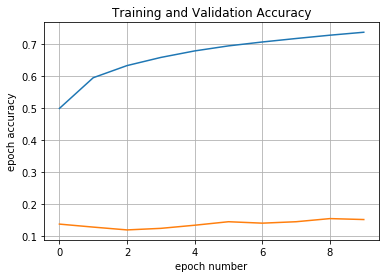

0.96044 0.66425 69.0834 0.137793


In [26]:
#best_val_acc = 0
#for reg_rate in [1e-3, 3e-3, 5e-3, 7e-3, 9e-3]:
#    print("Reg rate {0:.3g}".format(reg_rate))
train_loss, train_acc, val_loss, val_acc = train_model(X_train, y_train, X_val, y_val, 
    learn_rate=1e-3, reg_rate=0., epochs=10, batch_size=64, verbose=False)
#    if val_acc > best_val_acc:
#        best_rate = reg_rate
#        best_val_acc = val_acc
        
print(train_loss, train_acc, val_loss, val_acc)